Thanks for:

https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

https://www.kaggle.com/carlossouza/bayesian-experiments


v5 Crate features

v6 Add middle layer feature extraction

v7 Crate features with middle layer feature extraction

v8 Crate features with middle layer feature extraction

In [1]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

## Library

In [2]:
import albumentations
import copy
from collections import defaultdict
import cv2

from efficientnet_pytorch import model as enet
from functools import partial

import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import operator
import pandas as pd
import pymc3 as pm

import random
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder

from tqdm.notebook import tqdm
import typing as tp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler

from PIL import Image
import pydicom


import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ",torch.__version__)
print('Running on PyMC3 v{}'.format(pm.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Running on PyMC3 v3.9.2
cpu


## Utils

In [3]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Config

In [4]:
OUTPUT_DICT = './'
data_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression/"

train_image_folder = os.path.join(data_dir+'train')
test_image_folder = os.path.join(data_dir+'test')

train_ct_dic = os.path.join('../input/oscitrainedmodels/osci_train_ct_image_dict.256.pkl')

ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 42
seed_everything(seed=SEED)

N_FOLD = 4

n_epochs = 9999
train_bs = 32
valid_bs = 32
test_bs = 16

SIZE = 256

# Data Loading

In [5]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
tr = train.copy()
train[ID] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
print(train.shape)
train.head()

(1549, 8)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11


In [6]:
# construct train input

output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
    
train = output[output['Week_passed']!=0].reset_index(drop=True)
print(train.shape)
train.head()


(12144, 11)


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,Male,Ex-smoker,21


In [7]:
# construct test input

test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
ts = test.copy()

# Create test dataset with Bayesian approach
https://colab.research.google.com/drive/13WTKUlpYEtN0RNhzax_j8gbf84FuU1CF?authuser=1#scrollTo=jUeafaYrv9Em

In [8]:
# PercentをFVCに合わせて補正
# X * Percent / 100 = FVC
# X = FVC * 100 / Percent

dic = {}
for i in range(len(test)):
    X = int(test.FVC[i]*100/test.Percent[i])
    dic[test.Patient[i]] = X
dic

{'ID00419637202311204720264': 4302,
 'ID00421637202311550012437': 3338,
 'ID00422637202311677017371': 2517,
 'ID00423637202312137826377': 4156,
 'ID00426637202313170790466': 4072}

In [9]:
tr = pd.concat([tr, ts], axis=0, ignore_index=True).drop_duplicates()
le_id = LabelEncoder()
tr['PatientID'] = le_id.fit_transform(tr['Patient'])

In [10]:
n_patients = tr['Patient'].nunique()
FVC_obs = tr['FVC'].values
Weeks = tr['Weeks'].values
PatientID = tr['PatientID'].values

with pm.Model() as model_a:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)
    
    # Fitting the model
    trace_a = pm.sample(2000, tune=2000, target_accept=.9, init="adapt_diag")

In [11]:
pred_template = []
for p in tｓ['Patient'].unique():
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['Patient'] = p
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)
pred_template['PatientID'] = le_id.transform(pred_template['Patient'])

with model_a:
    pm.set_data({
        "PatientID_shared": pred_template['PatientID'].values.astype(int),
        "Weeks_shared": pred_template['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_template)).astype(int),
    })
    post_pred = pm.sample_posterior_predictive(trace_a)

In [12]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'Patient_Week', 'FVC', 'Confidence'])
df['Patient'] = pred_template['Patient']
df['Weeks'] = pred_template['Weeks']
df['Patient_Week'] = df['Patient'] + '_' + df['Weeks'].astype(str)
df['FVC'] = post_pred['FVC_like'].T.mean(axis=1)
df['Confidence'] = post_pred['FVC_like'].T.std(axis=1)
final = df[['Patient_Week', 'FVC', 'Confidence']]
final.to_csv('submission.csv', index=False)
print(final.shape)
final

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2870.328566,162.899335
1,ID00419637202311204720264_-11,2866.111977,161.991484
2,ID00419637202311204720264_-10,2857.909333,164.451954
3,ID00419637202311204720264_-9,2863.145807,162.984303
4,ID00419637202311204720264_-8,2854.962961,158.069054
...,...,...,...
725,ID00426637202313170790466_129,2712.184748,274.744090
726,ID00426637202313170790466_130,2709.917791,282.789233
727,ID00426637202313170790466_131,2713.745669,281.730437
728,ID00426637202313170790466_132,2706.959290,285.840029


In [13]:
test = test.rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'})
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['Week_passed'] = test['predict_Week'] - test['base_Week']
print(test.shape)
test

(730, 10)


,Patient_Week,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,2925,71.824968,73,Male,Never smoked,129
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,2925,71.824968,73,Male,Never smoked,130
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,2925,71.824968,73,Male,Never smoked,131
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,2925,71.824968,73,Male,Never smoked,132


In [14]:
test = test.drop(columns='base_FVC').merge(final[["Patient_Week", "FVC"]], on='Patient_Week')
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,70.186855,73,Male,Ex-smoker,-18,2870.328566
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,70.186855,73,Male,Ex-smoker,-17,2866.111977
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,70.186855,73,Male,Ex-smoker,-16,2857.909333
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,70.186855,73,Male,Ex-smoker,-15,2863.145807
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,70.186855,73,Male,Ex-smoker,-14,2854.962961
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,71.824968,73,Male,Never smoked,129,2712.184748
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,71.824968,73,Male,Never smoked,130,2709.917791
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,71.824968,73,Male,Never smoked,131,2713.745669
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,71.824968,73,Male,Never smoked,132,2706.959290


In [15]:
# Percent = FVC * 100 /X

for i in range(len(test)):
    Percent = test.FVC[i]*100 / dic[test.Patient[i]]
    test.base_Percent[i] = Percent
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.720794,73,Male,Ex-smoker,-18,2870.328566
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.622780,73,Male,Ex-smoker,-17,2866.111977
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.432109,73,Male,Ex-smoker,-16,2857.909333
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.553831,73,Male,Ex-smoker,-15,2863.145807
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.363621,73,Male,Ex-smoker,-14,2854.962961
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.605716,73,Male,Never smoked,129,2712.184748
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.550044,73,Male,Never smoked,130,2709.917791
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.644049,73,Male,Never smoked,131,2713.745669
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.477389,73,Male,Never smoked,132,2706.959290


In [16]:
#getting FVC for base week and setting it as base_FVC of patient
def get_base_FVC(data):
    df = data.copy()
    df['min_week'] = df.groupby('Patient')['predict_Week'].transform('min')
    base = df.loc[df.predict_Week == df.min_week][['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    base['nb']=1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    base = base[base.nb==1]
    base.drop('nb',axis =1,inplace=True)
    df = df.merge(base,on="Patient",how='left')
    df.drop(['min_week'], axis = 1)
    return df 

#For Inference
#getting Number of CT 
def get_N_CT(data, mode="test"):
    df = data.copy()
    N_CT = []
    for pt_id in df.Patient:
      if mode is "test":
        png_dir = os.path.join(test_image_folder, pt_id)
      if mode is "train":
        png_dir = os.path.join(train_image_folder, pt_id)
      files = os.listdir(png_dir)
      N_CT.append(len(files))
    df["N_CT"] = N_CT
    return df

# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-8
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [17]:
test["min_Weeks"] = np.nan
test = get_base_FVC(test)
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,min_Weeks,min_week,base_FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.720794,73,Male,Ex-smoker,-18,2870.328566,NaN,-12,2870.328566
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.622780,73,Male,Ex-smoker,-17,2866.111977,NaN,-12,2870.328566
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.432109,73,Male,Ex-smoker,-16,2857.909333,NaN,-12,2870.328566
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.553831,73,Male,Ex-smoker,-15,2863.145807,NaN,-12,2870.328566
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.363621,73,Male,Ex-smoker,-14,2854.962961,NaN,-12,2870.328566
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.605716,73,Male,Never smoked,129,2712.184748,NaN,-12,2950.337935
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.550044,73,Male,Never smoked,130,2709.917791,NaN,-12,2950.337935
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.644049,73,Male,Never smoked,131,2713.745669,NaN,-12,2950.337935
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.477389,73,Male,Never smoked,132,2706.959290,NaN,-12,2950.337935


In [18]:
test = test.drop(['min_Weeks', 'min_week'], axis = 1)
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,base_FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.720794,73,Male,Ex-smoker,-18,2870.328566,2870.328566
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.622780,73,Male,Ex-smoker,-17,2866.111977,2870.328566
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.432109,73,Male,Ex-smoker,-16,2857.909333,2870.328566
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.553831,73,Male,Ex-smoker,-15,2863.145807,2870.328566
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.363621,73,Male,Ex-smoker,-14,2854.962961,2870.328566
...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.605716,73,Male,Never smoked,129,2712.184748,2950.337935
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.550044,73,Male,Never smoked,130,2709.917791,2950.337935
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.644049,73,Male,Never smoked,131,2713.745669,2950.337935
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.477389,73,Male,Never smoked,132,2706.959290,2950.337935


In [19]:
train = get_N_CT(train, "train")
test = get_N_CT(test)

In [20]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)

data = data.reset_index(drop=True)
Splitdata=data['WHERE']
data = data.drop(columns='WHERE')

data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,9,30
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,11,30
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,13,30
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,15,30
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,21,30
...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,129,408
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,130,408
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,131,408
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,132,408


In [21]:
pt_min_dic = defaultdict()
pt_max_dic = defaultdict()
for pt_id in data.Patient.unique():
    pt_min = data.FVC[data.Patient==pt_id].min()
    pt_max = data.FVC[data.Patient==pt_id].max()
    pt_min_dic[pt_id] = pt_min
    pt_max_dic[pt_id] = pt_max

In [22]:
data["fvc_min"] = 0.0
data["fvc_max"] = 0.0

In [23]:
for i in range(len(data.Patient)):
    data["fvc_min"][i] = data.FVC[i] - pt_min_dic[data.Patient[i]]
    data["fvc_max"][i] = pt_max_dic[data.Patient[i]] - data.FVC[i]
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT,fvc_min,fvc_max
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,9,30,214.000000,101.000000
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,11,30,61.000000,254.000000
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,13,30,144.000000,171.000000
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,15,30,69.000000,246.000000
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,21,30,101.000000,214.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,129,408,5.225458,265.815252
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,130,408,2.958501,268.082209
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,131,408,6.786378,264.254331
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,132,408,0.000000,271.040710


In [24]:
data["fvc_min_ratio"] = 0.0
data["fvc_max_ratio"] = 0.0

In [25]:
for i in range(len(data.Patient)):
    data["fvc_min_ratio"][i] = data["fvc_min"][i] / data["base_FVC"][i]
    data["fvc_max_ratio"][i] = data["fvc_max"][i] / data["base_FVC"][i]
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT,fvc_min,fvc_max,fvc_min_ratio,fvc_max_ratio
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,9,30,214.000000,101.000000,0.092441,0.043629
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,11,30,61.000000,254.000000,0.026350,0.109719
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,13,30,144.000000,171.000000,0.062203,0.073866
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,15,30,69.000000,246.000000,0.029806,0.106263
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,21,30,101.000000,214.000000,0.043629,0.092441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,129,408,5.225458,265.815252,0.001771,0.090097
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,130,408,2.958501,268.082209,0.001003,0.090865
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,131,408,6.786378,264.254331,0.002300,0.089567
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,132,408,0.000000,271.040710,0.000000,0.091868


In [26]:
data["diff_fvc"] = data["base_FVC"] - data["FVC"]
data["diff_fvc_ratio"] = (data["base_FVC"] - data["FVC"])/data["base_FVC"]
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT,fvc_min,fvc_max,fvc_min_ratio,fvc_max_ratio,diff_fvc,diff_fvc_ratio
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,9,30,214.000000,101.000000,0.092441,0.043629,101.000000,0.043629
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,11,30,61.000000,254.000000,0.026350,0.109719,254.000000,0.109719
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,13,30,144.000000,171.000000,0.062203,0.073866,171.000000,0.073866
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,15,30,69.000000,246.000000,0.029806,0.106263,246.000000,0.106263
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,21,30,101.000000,214.000000,0.043629,0.092441,214.000000,0.092441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,129,408,5.225458,265.815252,0.001771,0.090097,238.153187,0.080721
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,130,408,2.958501,268.082209,0.001003,0.090865,240.420143,0.081489
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,131,408,6.786378,264.254331,0.002300,0.089567,236.592266,0.080192
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,132,408,0.000000,271.040710,0.000000,0.091868,243.378644,0.082492


In [27]:
data['diff_fvc2'] = (data['diff_fvc'] - data['diff_fvc'].min() ) / (data['diff_fvc'].max() - data['diff_fvc'].min())
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT,fvc_min,fvc_max,fvc_min_ratio,fvc_max_ratio,diff_fvc,diff_fvc_ratio,diff_fvc2
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,9,30,214.000000,101.000000,0.092441,0.043629,101.000000,0.043629,0.531115
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,11,30,61.000000,254.000000,0.026350,0.109719,254.000000,0.109719,0.578250
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,13,30,144.000000,171.000000,0.062203,0.073866,171.000000,0.073866,0.552680
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,15,30,69.000000,246.000000,0.029806,0.106263,246.000000,0.106263,0.575786
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,21,30,101.000000,214.000000,0.043629,0.092441,214.000000,0.092441,0.565927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,129,408,5.225458,265.815252,0.001771,0.090097,238.153187,0.080721,0.573368
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,130,408,2.958501,268.082209,0.001003,0.090865,240.420143,0.081489,0.574067
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,131,408,6.786378,264.254331,0.002300,0.089567,236.592266,0.080192,0.572887
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,132,408,0.000000,271.040710,0.000000,0.091868,243.378644,0.082492,0.574978


In [28]:
Age = []
for i in range(len(data)):
  Pt_base_age = data.base_Age[data.Patient == data.Patient[i]].min()
  # 365/7 = 52.14
  # 1/52.14 = 0.01917
  Pt_age = 0.0192*data.predict_Week[i] + Pt_base_age
  Age.append(Pt_age)

data["Age"] = Age
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,N_CT,fvc_min,fvc_max,fvc_min_ratio,fvc_max_ratio,diff_fvc,diff_fvc_ratio,diff_fvc2,Age
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,9,30,214.000000,101.000000,0.092441,0.043629,101.000000,0.043629,0.531115,79.0960
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,11,30,61.000000,254.000000,0.026350,0.109719,254.000000,0.109719,0.578250,79.1344
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,13,30,144.000000,171.000000,0.062203,0.073866,171.000000,0.073866,0.552680,79.1728
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,15,30,69.000000,246.000000,0.029806,0.106263,246.000000,0.106263,0.575786,79.2112
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,21,30,101.000000,214.000000,0.043629,0.092441,214.000000,0.092441,0.565927,79.3264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,129,408,5.225458,265.815252,0.001771,0.090097,238.153187,0.080721,0.573368,75.4768
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,130,408,2.958501,268.082209,0.001003,0.090865,240.420143,0.081489,0.574067,75.4960
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,131,408,6.786378,264.254331,0.002300,0.089567,236.592266,0.080192,0.572887,75.5152
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,132,408,0.000000,271.040710,0.000000,0.091868,243.378644,0.082492,0.574978,75.5344


In [29]:
# typical_FVC_cluster
fvc_cluster = {}

set_fvc = sorted(list(set(round(data.FVC/data.base_Percent*100, -2))))
for idx, fvc in enumerate(set_fvc, 1):
  fvc_cluster[fvc] = idx
fvc_cluster

{1000.0: 1,
 1200.0: 2,
 1300.0: 3,
 1400.0: 4,
 1500.0: 5,
 1600.0: 6,
 1700.0: 7,
 1800.0: 8,
 1900.0: 9,
 2000.0: 10,
 2100.0: 11,
 2200.0: 12,
 2300.0: 13,
 2400.0: 14,
 2500.0: 15,
 2600.0: 16,
 2700.0: 17,
 2800.0: 18,
 2900.0: 19,
 3000.0: 20,
 3100.0: 21,
 3200.0: 22,
 3300.0: 23,
 3400.0: 24,
 3500.0: 25,
 3600.0: 26,
 3700.0: 27,
 3800.0: 28,
 3900.0: 29,
 4000.0: 30,
 4100.0: 31,
 4200.0: 32,
 4300.0: 33,
 4400.0: 34,
 4500.0: 35,
 4600.0: 36,
 4700.0: 37,
 4800.0: 38,
 4900.0: 39,
 5000.0: 40,
 5100.0: 41,
 5200.0: 42,
 5300.0: 43,
 5400.0: 44,
 5500.0: 45,
 5600.0: 46,
 5700.0: 47,
 5800.0: 48,
 5900.0: 49,
 6000.0: 50,
 6100.0: 51,
 6200.0: 52,
 6300.0: 53,
 6400.0: 54,
 6500.0: 55,
 6600.0: 56,
 6700.0: 57,
 6800.0: 58,
 6900.0: 59,
 7000.0: 60}

In [30]:
typical_FVC_cluster = []
for i in range(len(data)):
  typical_FVC = round(data.FVC[i]/data.base_Percent[i]*100, -2)
  typical_FVC_cluster.append(fvc_cluster[typical_FVC])

data["typical_FVC_cluster"] = typical_FVC_cluster
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,N_CT,fvc_min,fvc_max,fvc_min_ratio,fvc_max_ratio,diff_fvc,diff_fvc_ratio,diff_fvc2,Age,typical_FVC_cluster
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,30,214.000000,101.000000,0.092441,0.043629,101.000000,0.043629,0.531115,79.0960,28
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,30,61.000000,254.000000,0.026350,0.109719,254.000000,0.109719,0.578250,79.1344,25
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,30,144.000000,171.000000,0.062203,0.073866,171.000000,0.073866,0.552680,79.1728,27
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,30,69.000000,246.000000,0.029806,0.106263,246.000000,0.106263,0.575786,79.2112,26
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,30,101.000000,214.000000,0.043629,0.092441,214.000000,0.092441,0.565927,79.3264,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,...,408,5.225458,265.815252,0.001771,0.090097,238.153187,0.080721,0.573368,75.4768,31
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,...,408,2.958501,268.082209,0.001003,0.090865,240.420143,0.081489,0.574067,75.4960,31
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,...,408,6.786378,264.254331,0.002300,0.089567,236.592266,0.080192,0.572887,75.5152,31
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,...,408,0.000000,271.040710,0.000000,0.091868,243.378644,0.082492,0.574978,75.5344,31


In [31]:
tmp1 = CreateFeat(data[["base_FVC", "diff_fvc"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data


Crated 4 columns



Removed 1 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,fvc_min_ratio,fvc_max_ratio,diff_fvc,diff_fvc_ratio,diff_fvc2,Age,typical_FVC_cluster,base_FVC_diff_fvc_div,diff_fvc_base_FVC_prd,diff_fvc_base_FVC_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,0.092441,0.043629,101.000000,0.043629,0.531115,79.0960,28,23.0,233815.000000,0.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,0.026350,0.109719,254.000000,0.109719,0.578250,79.1344,25,9.0,588010.000000,0.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,0.062203,0.073866,171.000000,0.073866,0.552680,79.1728,27,14.0,395865.000000,0.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,0.029806,0.106263,246.000000,0.106263,0.575786,79.2112,26,9.0,569490.000000,0.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,Male,Ex-smoker,...,0.043629,0.092441,214.000000,0.092441,0.565927,79.3264,26,11.0,495410.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,Male,Never smoked,...,0.001771,0.090097,238.153187,0.080721,0.573368,75.4768,31,12.0,702632.381036,0.0
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,Male,Never smoked,...,0.001003,0.090865,240.420143,0.081489,0.574067,75.4960,31,12.0,709320.669588,0.0
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,Male,Never smoked,...,0.002300,0.089567,236.592266,0.080192,0.572887,75.5152,31,12.0,698027.136827,0.0
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,Male,Never smoked,...,0.000000,0.091868,243.378644,0.082492,0.574978,75.5344,31,12.0,718049.246580,0.0


In [32]:
# log transform
data["log_N_CT"] = np.log1p(data.N_CT)
data["log_diff_fvc_base_FVC_prd"] = np.log1p(data.diff_fvc_base_FVC_prd) 

In [33]:
Encoding = {"Currently smokes": 2, "Ex-smoker": 1, "Never smoked": 0, "Male": 1, "Female":0}
data['SmokingStatus'] = data.SmokingStatus.map(Encoding)
data["Sex"] = data.Sex.map(Encoding)

In [34]:
# clipping
clipping = data.columns[10:]
for col in clipping:
  upperbound, lowerbound = np.percentile(data[col], [1, 99])
  data[col] = np.clip(data[col], upperbound, lowerbound)

In [35]:
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")#, "skew","kurt")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [36]:
important_col = ["diff_fvc", "Week_passed", "base_FVC"]

In [37]:
tmp = CreateFeat2(data[important_col])

data = pd.concat([data, tmp], axis=1)
data= data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp], axis=1)

data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 42 columns



Removed 84 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,base_FVC_Week_passed_median,Week_passed_diff_fvc_mad,base_FVC_diff_fvc_mad,base_FVC_Week_passed_mad,Week_passed_diff_fvc_var,base_FVC_diff_fvc_var,base_FVC_Week_passed_var,Week_passed_diff_fvc_std,base_FVC_diff_fvc_std,base_FVC_Week_passed_std
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,1162.000000,46.000000,1107.000000,1153.000000,4232.000000,2.450898e+06,2.658818e+06,65.053824,1565.534414,1630.588237
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,1163.000000,121.500000,1030.500000,1152.000000,29524.500000,2.123860e+06,2.654208e+06,171.826948,1457.347076,1629.174024
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,1164.000000,79.000000,1072.000000,1151.000000,12482.000000,2.298368e+06,2.649602e+06,111.722871,1516.036939,1627.759810
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,1165.000000,115.500000,1034.500000,1150.000000,26680.500000,2.140380e+06,2.645000e+06,163.341666,1463.003930,1626.345597
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,1168.000000,96.500000,1050.500000,1147.000000,18624.500000,2.207100e+06,2.631218e+06,136.471609,1485.631347,1622.102956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,1524.668967,69.576593,1356.092374,1425.668967,9681.804688,3.677973e+06,4.065064e+06,98.396162,1917.804227,2016.200389
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,1524.668967,70.710072,1354.958896,1425.668967,9999.828493,3.671827e+06,4.065064e+06,99.999142,1916.201247,2016.200389
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,1524.668967,68.796133,1356.872834,1425.668967,9465.815805,3.682208e+06,4.065064e+06,97.292424,1918.907965,2016.200389
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,1524.668967,72.189322,1353.479645,1425.668967,10422.596457,3.663814e+06,4.065064e+06,102.091118,1914.109271,2016.200389


# CT images extraction

In [38]:
#https://www.kaggle.com/unforgiven/osic-comprehensive-eda

import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu, median
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border
from skimage import exposure
from scipy.stats import describe

def load_scan(dicom_dir):
  files = os.listdir(dicom_dir)  
  files.sort(key=lambda x: (int(x[:-4]), x[:-3]))
  dcms = []
  len_files = len(files)

  if len_files < 15:
    Point = 2*len(files)//10+2
    dicom_file = os.path.join(dicom_dir, files[Point])
    dcms.append(dicom_file)

  elif len_files < 33: # 25% percentile
    Point = 3*len(files)//10
    Range = 3
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)

  elif len_files > 500: # 75% percentile
    Point = 6*len(files)//10
    Range = 7
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)
  else:
    Point = 4*len(files)//10
    Range = 5
    for file in files[Point: Point+Range]:
      dicom_file = os.path.join(dicom_dir, file)
      dcms.append(dicom_file)
      
  slices = []
  for scan in  dcms:
        with pydicom.dcmread(scan) as s:
            slices.append(s)
    
  slices.sort(key = lambda x: int(x.InstanceNumber))

  try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
    
  for s in slices:
        s.SliceThickness = slice_thickness
        
  return slices

def get_pixels_hu(slices):
    imags = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    imags = imags.astype(np.int16)
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    if slices[0].RescaleIntercept == -1024:
       imags[imags <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    center = slices[0].WindowCenter

    try:thresh = center*0.9
    except:thresh = center[0]*0.9
    
    if slope != 1:
        imags = slope * image.astype(np.float64)
        imags = image.astype(np.int16)
        
    imags += np.int16(intercept)

    imags = np.array(imags, dtype=np.int16)


    binaries = []
    for imag in imags:
      binary = imag <= thresh
      binaries.append(binary)
    mean_img = np.mean(binaries, axis=0)
    
    return mean_img

def conv_img(mean_img):
  h, w = mean_img.shape[:2]
  if h == w:
    h1, h2 = int(h * 0.33), int(h * 0.7)
    w1, w2 = int(w * 0.13), int(w * 0.87)
  if h > w:
    a, b = h/w, w/h
    h1, h2 = int(h * 0.3*a), int(h * 0.7*b)
    w1, w2 = int(w * 0.13), int(w * 0.87)
  if h < w:
    a, b = w/h, h/w
    h1, h2 = int(h * 0.4), int(h * 0.67)
    w1, w2 = int(w * 0.3*a), int(w * 0.8*b)
    

  mean_img = mean_img[h1: h2, w1: w2]
  mean_img = cv2.resize(mean_img, (SIZE, SIZE))

  stacked_img = np.stack((mean_img,)*3, -1)
  stacked_img = exposure.equalize_adapthist(stacked_img)
  

  return stacked_img

# Middle Layer Feature Extraction

In [39]:
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [40]:
from os import makedirs
from os.path import expanduser, exists, join
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [41]:
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

In [42]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import GlobalMaxPooling2D, Input
from keras.models import Model

In [43]:
base_model = InceptionV3(include_top=False, 
                         weights='imagenet', 
                         input_tensor=Input((SIZE, SIZE, 3)))

In [44]:
# Take out the following layers.
# mixed7  (None, 17, 17, 768) 
feature = base_model.get_layer('mixed7')
print(type(feature))  # <class 'keras.layers.merge.Concatenate'>
print(feature.name, feature.output_shape)  # mixed7 (None, 17, 17, 768)

# Add Global Average Polling layer
output = GlobalMaxPooling2D()(feature.output)

# Create model
model = Model(inputs=base_model.input, outputs=output)
print(model.output_shape)  # (None, 768)

<class 'tensorflow.python.keras.layers.merge.Concatenate'>
mixed7 (None, 14, 14, 768)
(None, 768)


In [45]:
# Loading train ct images dictionay file.
import pickle
from collections import defaultdict

with open(train_ct_dic, 'rb') as f:
    data_dic = pickle.load(f)

In [46]:
len(data_dic)

176

In [47]:
tmp_df = test.reset_index(drop=True)

for pt_id in tqdm(set(list(tmp_df.Patient))):
  dicom_dir = os.path.join(test_image_folder, pt_id)
  patient = load_scan(dicom_dir)
  mean_img = get_pixels_hu(patient)
  stacked_img = conv_img(mean_img)
  data_dic[pt_id]=stacked_img

In [48]:
len(data_dic)

176

In [49]:
def processed_img(pt_id):
  img = data_dic[pt_id]
  img = np.expand_dims(img, axis=0)
  return img

In [50]:
pt_lst = list(set(data.Patient))
data_img = processed_img(pt_lst[0])

In [51]:
for pt_id in tqdm(pt_lst[1:]):
  img = processed_img(pt_id)
  data_img = np.vstack([data_img, img])

(176, 768)
PCA:(176, 100)


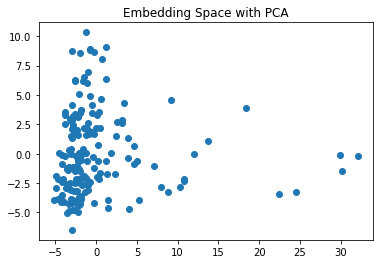

UMAP:(176, 3)


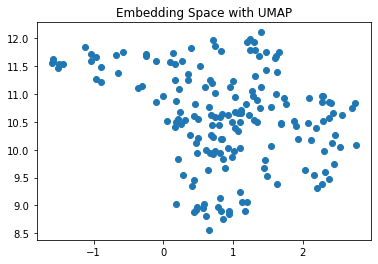

In [52]:
from sklearn.decomposition import PCA
from umap import UMAP

pca = PCA(n_components=100, random_state=42)
umap = UMAP(n_components=3, random_state=42)

# Extract Middle Layer Features
img_features = model.predict(data_img)
print(img_features.shape)

pca.fit(img_features)
# PCA
x = pca.fit_transform(img_features)
print(f"PCA:{x.shape}")
plt.scatter(x[:, 0], x[:, 1])
plt.title("Embedding Space with PCA")
plt.show()

#UMAP
x = umap.fit_transform(x)
print(f"UMAP:{x.shape}")
plt.scatter(x[:, 0], x[:, 1])
plt.title("Embedding Space with UMAP")
plt.show()

In [53]:
feature_dic = defaultdict()

for idx, pt_id in tqdm(enumerate(set(list(data.Patient)))):
  feature_dic[pt_id] = x[idx]
feature_dic

defaultdict(None,
            {'ID00093637202205278167493': array([ 2.2730281, 10.970086 ,  5.410506 ], dtype=float32),
             'ID00248637202266698862378': array([1.1999068, 9.068058 , 4.887327 ], dtype=float32),
             'ID00134637202223873059688': array([-0.8892249, 11.211021 ,  4.630586 ], dtype=float32),
             'ID00086637202203494931510': array([ 2.7639606, 10.080651 ,  5.1750064], dtype=float32),
             'ID00111637202210956877205': array([ 2.742984, 10.832778,  6.215431], dtype=float32),
             'ID00196637202246668775836': array([0.48559186, 8.979414  , 5.6204653 ], dtype=float32),
             'ID00127637202219096738943': array([ 2.3732054, 10.856204 ,  5.4555664], dtype=float32),
             'ID00125637202218590429387': array([1.6284302, 9.392704 , 4.8079944], dtype=float32),
             'ID00090637202204766623410': array([0.65096515, 8.562064  , 6.026504  ], dtype=float32),
             'ID00020637202178344345685': array([-0.30177256, 11.137912  

In [54]:
features = feature_dic[data.Patient[0]]
for pt_id in data.Patient[1:]:
  features = np.vstack([features, feature_dic[pt_id]])
features

array([[ 2.368213 , 10.575166 ,  5.109336 ],
       [ 2.368213 , 10.575166 ,  5.109336 ],
       [ 2.368213 , 10.575166 ,  5.109336 ],
       ...,
       [ 0.683946 , 10.619443 ,  6.6615596],
       [ 0.683946 , 10.619443 ,  6.6615596],
       [ 0.683946 , 10.619443 ,  6.6615596]], dtype=float32)

In [55]:
img_feature1 = features[:,0].tolist()
img_feature2 = features[:,1].tolist()
img_feature3 = features[:,2].tolist()

In [56]:
data["img_feature1"] = img_feature1
data["img_feature2"] = img_feature2
data["img_feature3"] = img_feature3
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,base_FVC_Week_passed_mad,Week_passed_diff_fvc_var,base_FVC_diff_fvc_var,base_FVC_Week_passed_var,Week_passed_diff_fvc_std,base_FVC_diff_fvc_std,base_FVC_Week_passed_std,img_feature1,img_feature2,img_feature3
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,1153.000000,4232.000000,2.450898e+06,2.658818e+06,65.053824,1565.534414,1630.588237,2.368213,10.575166,5.109336
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,1152.000000,29524.500000,2.123860e+06,2.654208e+06,171.826948,1457.347076,1629.174024,2.368213,10.575166,5.109336
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,1151.000000,12482.000000,2.298368e+06,2.649602e+06,111.722871,1516.036939,1627.759810,2.368213,10.575166,5.109336
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,1150.000000,26680.500000,2.140380e+06,2.645000e+06,163.341666,1463.003930,1626.345597,2.368213,10.575166,5.109336
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,1147.000000,18624.500000,2.207100e+06,2.631218e+06,136.471609,1485.631347,1622.102956,2.368213,10.575166,5.109336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,1425.668967,9681.804688,3.677973e+06,4.065064e+06,98.396162,1917.804227,2016.200389,0.683946,10.619443,6.661560
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,1425.668967,9999.828493,3.671827e+06,4.065064e+06,99.999142,1916.201247,2016.200389,0.683946,10.619443,6.661560
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,1425.668967,9465.815805,3.682208e+06,4.065064e+06,97.292424,1918.907965,2016.200389,0.683946,10.619443,6.661560
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,1425.668967,10422.596457,3.663814e+06,4.065064e+06,102.091118,1914.109271,2016.200389,0.683946,10.619443,6.661560


In [57]:
tmp1 = CreateFeat(data[["base_FVC_diff_fvc_div", "img_feature1"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data


Crated 4 columns



Removed 1 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,base_FVC_Week_passed_var,Week_passed_diff_fvc_std,base_FVC_diff_fvc_std,base_FVC_Week_passed_std,img_feature1,img_feature2,img_feature3,base_FVC_diff_fvc_div_img_feature1_div,img_feature1_base_FVC_diff_fvc_div_prd,img_feature1_base_FVC_diff_fvc_div_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,2.658818e+06,65.053824,1565.534414,1630.588237,2.368213,10.575166,5.109336,10.0,54.468898,0.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,2.654208e+06,171.826948,1457.347076,1629.174024,2.368213,10.575166,5.109336,4.0,21.313916,0.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,2.649602e+06,111.722871,1516.036939,1627.759810,2.368213,10.575166,5.109336,6.0,33.154981,0.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,2.645000e+06,163.341666,1463.003930,1626.345597,2.368213,10.575166,5.109336,4.0,21.313916,0.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,2.631218e+06,136.471609,1485.631347,1622.102956,2.368213,10.575166,5.109336,5.0,26.050342,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,4.065064e+06,98.396162,1917.804227,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,4.065064e+06,99.999142,1916.201247,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,4.065064e+06,97.292424,1918.907965,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,4.065064e+06,102.091118,1914.109271,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0


In [58]:
tmp1 = CreateFeat(data[["base_FVC_diff_fvc_div", "img_feature2"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data


Crated 4 columns



Removed 1 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,base_FVC_Week_passed_std,img_feature1,img_feature2,img_feature3,base_FVC_diff_fvc_div_img_feature1_div,img_feature1_base_FVC_diff_fvc_div_prd,img_feature1_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature2_div,img_feature2_base_FVC_diff_fvc_div_prd,img_feature2_base_FVC_diff_fvc_div_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,1630.588237,2.368213,10.575166,5.109336,10.0,54.468898,0.0,2.0,243.228812,0.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,1629.174024,2.368213,10.575166,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,1627.759810,2.368213,10.575166,5.109336,6.0,33.154981,0.0,1.0,148.052320,1.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,1626.345597,2.368213,10.575166,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,1622.102956,2.368213,10.575166,5.109336,5.0,26.050342,0.0,1.0,116.326823,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,2016.200389,0.683946,10.619443,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0


In [59]:
tmp1 = CreateFeat(data[["base_FVC_diff_fvc_div", "img_feature3"]])
data = pd.concat([data, tmp1], axis=1)
#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp１ = ReduceCol(data.iloc[:,10:])
data = pd.concat([data.iloc[:,:10], tmp１], axis=1)
data


Crated 4 columns



Removed 1 constant & duplicated columns


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,img_feature3,base_FVC_diff_fvc_div_img_feature1_div,img_feature1_base_FVC_diff_fvc_div_prd,img_feature1_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature2_div,img_feature2_base_FVC_diff_fvc_div_prd,img_feature2_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature3_div,img_feature3_base_FVC_diff_fvc_div_prd,img_feature3_base_FVC_diff_fvc_div_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,5.109336,10.0,54.468898,0.0,2.0,243.228812,0.0,5.0,117.514726,0.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0,2.0,45.984023,1.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,5.109336,6.0,33.154981,0.0,1.0,148.052320,1.0,3.0,71.530703,0.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0,2.0,45.984023,1.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,5.109336,5.0,26.050342,0.0,1.0,116.326823,1.0,2.0,56.202695,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0


In [60]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any', axis=1)
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,img_feature3,base_FVC_diff_fvc_div_img_feature1_div,img_feature1_base_FVC_diff_fvc_div_prd,img_feature1_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature2_div,img_feature2_base_FVC_diff_fvc_div_prd,img_feature2_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature3_div,img_feature3_base_FVC_diff_fvc_div_prd,img_feature3_base_FVC_diff_fvc_div_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,5.109336,10.0,54.468898,0.0,2.0,243.228812,0.0,5.0,117.514726,0.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0,2.0,45.984023,1.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,5.109336,6.0,33.154981,0.0,1.0,148.052320,1.0,3.0,71.530703,0.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0,2.0,45.984023,1.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,5.109336,5.0,26.050342,0.0,1.0,116.326823,1.0,2.0,56.202695,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0


In [61]:
# clipping
clipping = data.columns[10:]
for col in clipping:
  upperbound, lowerbound = np.percentile(data[col], [1, 99])
  data[col] = np.clip(data[col], upperbound, lowerbound)

In [62]:
# clean up column names with a simple instruction
# https://stackoverflow.com/questions/60698860/how-to-deal-with-do-not-support-non-ascii-characters-in-feature-name-error-whe
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,img_feature3,base_FVC_diff_fvc_div_img_feature1_div,img_feature1_base_FVC_diff_fvc_div_prd,img_feature1_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature2_div,img_feature2_base_FVC_diff_fvc_div_prd,img_feature2_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature3_div,img_feature3_base_FVC_diff_fvc_div_prd,img_feature3_base_FVC_diff_fvc_div_div
0,ID00007637202177411956430,5,2214.000000,ID00007637202177411956430_5,-4,2315.000000,58.253649,79,1,1,...,5.109336,10.0,54.468898,0.0,2.0,243.228812,0.0,5.0,117.514726,0.0
1,ID00007637202177411956430,7,2061.000000,ID00007637202177411956430_7,-4,2315.000000,58.253649,79,1,1,...,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0,2.0,45.984023,1.0
2,ID00007637202177411956430,9,2144.000000,ID00007637202177411956430_9,-4,2315.000000,58.253649,79,1,1,...,5.109336,6.0,33.154981,0.0,1.0,148.052320,1.0,3.0,71.530703,0.0
3,ID00007637202177411956430,11,2069.000000,ID00007637202177411956430_11,-4,2315.000000,58.253649,79,1,1,...,5.109336,4.0,21.313916,0.0,1.0,95.176492,1.0,2.0,45.984023,1.0
4,ID00007637202177411956430,17,2101.000000,ID00007637202177411956430_17,-4,2315.000000,58.253649,79,1,1,...,5.109336,5.0,26.050342,0.0,1.0,116.326823,1.0,2.0,56.202695,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,6.661560,18.0,8.207352,0.0,1.0,127.433315,1.0,2.0,79.938715,1.0


In [63]:
data['WHERE'] = Splitdata
data

train = data[data['WHERE']=="train"]
test = data[data['WHERE']=="test"]
test

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,base_FVC_diff_fvc_div_img_feature1_div,img_feature1_base_FVC_diff_fvc_div_prd,img_feature1_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature2_div,img_feature2_base_FVC_diff_fvc_div_prd,img_feature2_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature3_div,img_feature3_base_FVC_diff_fvc_div_prd,img_feature3_base_FVC_diff_fvc_div_div,WHERE
12144,ID00419637202311204720264,-12,2870.328566,ID00419637202311204720264_-12,6,2870.328566,66.720794,73,1,1,...,683.0,593.625275,0.0,64.27,6837.011423,0.0,112.0,3541.273225,0.0,test
12145,ID00419637202311204720264,-11,2866.111977,ID00419637202311204720264_-11,6,2870.328566,66.622780,73,1,1,...,617.0,593.625275,0.0,64.27,6294.310916,0.0,112.0,3541.273225,0.0,test
12146,ID00419637202311204720264,-10,2857.909333,ID00419637202311204720264_-10,6,2870.328566,66.432109,73,1,1,...,209.0,255.075130,0.0,25.00,2135.074628,0.0,40.0,1343.869733,0.0,test
12147,ID00419637202311204720264,-9,2863.145807,ID00419637202311204720264_-9,6,2870.328566,66.553831,73,1,1,...,362.0,441.688538,0.0,43.00,3697.098923,0.0,69.0,2327.047157,0.0,test
12148,ID00419637202311204720264,-8,2854.962961,ID00419637202311204720264_-8,6,2870.328566,66.363621,73,1,1,...,169.0,206.489391,0.0,20.00,1728.393746,0.0,32.0,1087.894546,0.0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,2712.184748,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,18.0,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test
12870,ID00426637202313170790466,130,2709.917791,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,18.0,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test
12871,ID00426637202313170790466,131,2713.745669,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,18.0,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test
12872,ID00426637202313170790466,132,2706.959290,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,18.0,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test


In [64]:
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
print(submission.shape)
submission.head()

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [65]:
# For infenrece effnet
submission2 = submission.copy()
test2 = test.copy()

# Prepare folds

In [66]:
folds = train[[ID, 'Patient', TARGET]].copy()
#Fold = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
Fold = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds

,Patient_Week,Patient,FVC,fold
0,ID00007637202177411956430_5,ID00007637202177411956430,2214.0,2
1,ID00007637202177411956430_7,ID00007637202177411956430,2061.0,2
2,ID00007637202177411956430_9,ID00007637202177411956430,2144.0,2
3,ID00007637202177411956430_11,ID00007637202177411956430,2069.0,2
4,ID00007637202177411956430_17,ID00007637202177411956430,2101.0,2
...,...,...,...,...
12139,ID00426637202313170790466_11,ID00426637202313170790466,2976.0,0
12140,ID00426637202313170790466_13,ID00426637202313170790466,2712.0,0
12141,ID00426637202313170790466_19,ID00426637202313170790466,2978.0,0
12142,ID00426637202313170790466_31,ID00426637202313170790466,2908.0,0


# Dataset

In [67]:
class OsciDataset(Dataset):
    
  def __init__(self, image_paths, data_dic, targets, augmentations=None, meta_features = None):
      """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
      """
      self.image_paths = image_paths
      self.data_dic = data_dic
      self.targets = targets
      self.augmentations = augmentations
      self.meta_features = meta_features

  def __len__(self):
      return len(self.image_paths)

  def get_targets(self):
      return list(self.targets)

  def __getitem__(self, idx):
      img = self.data_dic[self.image_paths[idx].split("/")[5]]
      
      if self.augmentations is not None:
          augmented = self.augmentations(image=img)
          img = augmented["image"]
            
      if self.meta_features is not None:
        meta = self.meta_features[idx]
        meta = torch.tensor(meta)
        
      stacked_img = img.transpose(2, 0, 1)
      
      targets = self.targets[idx]

      return {
            "image": (torch.tensor(stacked_img), meta),
            "targets": torch.tensor(targets),
        }

# Augmentations

In [68]:
valid_aug = albumentations.Compose([])

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


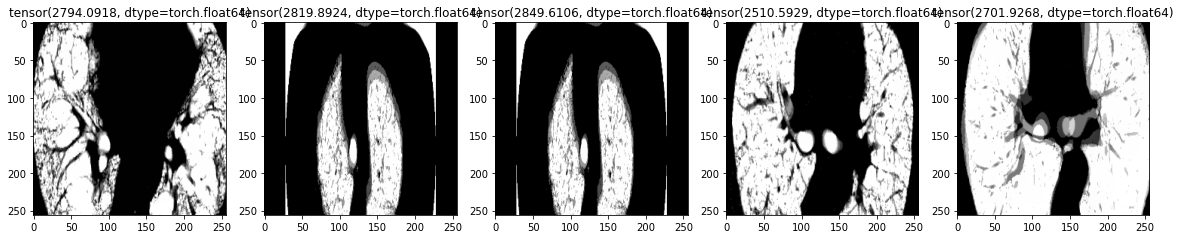

In [69]:
tmp_pt_id = test.Patient.values.tolist()
tmp_images_dir = [os.path.join(test_image_folder, tmp_pt_id[i]) for i in range(len(tmp_pt_id))]
tmp_targets = test.FVC.values
tmp_meta = np.array(test['predict_Week'].values, dtype=np.float32)

dataset_show = OsciDataset(image_paths = tmp_images_dir, data_dic=data_dic, targets=tmp_targets, augmentations=valid_aug, meta_features = tmp_meta)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

fig, axes = plt.subplots(1, 5)
for i in range(5):
  idx = np.random.randint(0, len(dataset_show))
  data = dataset_show[idx]
  imag, _ = data["image"]
  print(imag.shape)
  axes[i].imshow(imag.transpose(0, 1).transpose(1, 2).squeeze())
  axes[i].set_title(data["targets"])

# Model

In [70]:
class MyBatchNorm1d(nn.BatchNorm1d):
    def __init__(self, *kargs, **kwargs):
        super(MyBatchNorm1d, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        self.running_var.data = torch.round(self.running_var.data)
        
        out = F.batch_norm(input, self.running_mean, self.running_var,self.weight, self.bias, self.training, self.momentum, self.eps)
        
        return out

In [71]:
class enetv2(nn.Module):
    def __init__(self, backbone, n_features: int):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        #self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        
        self.cnn = nn.Sequential(nn.Linear(self.enet._fc.in_features, 250, bias=True),
                                 MyBatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1)
                                 )

        self.meta = nn.Sequential(nn.Linear(n_features, 500, bias=True),
                                  MyBatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.25),
                                  nn.Linear(500, 250),  
                                  MyBatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.25)
                                  )
        
        self.enet._fc = nn.Identity()
        self.out = nn.Linear(250 + 250, 3)
        
    def extract(self, x):
        return self.enet(x)

    def forward(self, inputs):
        x, meta = inputs
        x = self.extract(x)
        x = self.cnn(x)
        meta = self.meta(meta)
        x = torch.cat((x, meta), 1)
        out = self.out(x)
        
        return out

## Custom Objective / Metric

The competition evaluation metric is:

$
\displaystyle \sigma_{clipped} = \max \left ( \sigma, 70 \right ) \\
\displaystyle \Delta = \min \left ( \|FVC_{ture} - FVC_{predicted}\|, 1000 \right ) \\
\displaystyle f_{metric} = - \frac{\sqrt{2} \Delta}{\sigma_{clipped}} - \ln \left( \sqrt{2} \sigma_{clipped} \right) .
$

This is too complex to directly optimize by custom metric.
Here I use negative loglilelihood loss (_NLL_) of gaussian.  

Let $FVC_{ture}$ is $t$ and $FVC_{predicted}$ is $\mu$, the _NLL_ $l$ is formulated by:

$
\displaystyle l\left( t, \mu, \sigma \right) =
-\ln \left [ \frac{1}{\sqrt{2 \pi} \sigma} \exp \left \{ - \frac{\left(t - \mu \right)^2}{2 \sigma^2} \right \} \right ]
= \frac{\left(t - \mu \right)^2}{2 \sigma^2} + \ln \left( \sqrt{2 \pi} \sigma \right).
$

`grad` and `hess` are calculated as follows:

$
\displaystyle  \frac{\partial l}{\partial \mu } = -\frac{t - \mu}{\sigma^2} \ , \ \frac{\partial^2 l}{\partial \mu^2 } = \frac{1}{\sigma^2}
$

$
\displaystyle \frac{\partial l}{\partial \sigma}
=-\frac{\left(t - \mu \right)^2}{\sigma^3} + \frac{1}{\sigma} = \frac{1}{\sigma} \left\{ 1 - \left ( \frac{t - \mu}{\sigma} \right)^2 \right \}
\\
\displaystyle \frac{\partial^2 l}{\partial \sigma^2}
= -\frac{1}{\sigma^2} \left\{ 1 - \left ( \frac{t - \mu}{\sigma} \right)^2 \right \}
+\frac{1}{\sigma} \frac{2 \left(t - \mu \right)^2 }{\sigma^3}
= -\frac{1}{\sigma^2} \left\{ 1 - 3 \left ( \frac{t - \mu}{\sigma} \right)^2 \right \}
$

For numerical stability, I replace $\sigma$ with $\displaystyle \tilde{\sigma} := \log\left(1 + \mathrm{e}^{\sigma} \right).$

$
\displaystyle l'\left( t, \mu, \sigma \right)
= \frac{\left(t - \mu \right)^2}{2 \tilde{\sigma}^2} + \ln \left( \sqrt{2 \pi} \tilde{\sigma} \right).
$

$
\displaystyle \frac{\partial l'}{\partial \mu } = -\frac{t - \mu}{\tilde{\sigma}^2} \ , \ \frac{\partial^2 l}{\partial \mu^2 } = \frac{1}{\tilde{\sigma}^2}
$
<br>

$
\displaystyle \frac{\partial l'}{\partial \sigma}
= \frac{1}{\tilde{\sigma}} \left\{ 1 - \left ( \frac{t - \mu}{\tilde{\sigma}} \right)^2 \right \} \frac{\partial \tilde{\sigma}}{\partial \sigma}
\\
\displaystyle \frac{\partial^2 l'}{\partial \sigma^2}
= -\frac{1}{\tilde{\sigma}^2}  \left\{ 1 - 3 \left ( \frac{t - \mu}{\tilde{\sigma}} \right)^2 \right \}
\left( \frac{\partial \tilde{\sigma}}{\partial \sigma} \right) ^2
+\frac{1}{\tilde{\sigma}} \left\{ 1 - \left ( \frac{t - \mu}{\tilde{\sigma}} \right)^2 \right \} \frac{\partial^2 \tilde{\sigma}}{\partial \sigma^2}
$

, where  

$
\displaystyle
\frac{\partial \tilde{\sigma}}{\partial \sigma} = \frac{1}{1 + \mathrm{e}^{-\sigma}} \\
\displaystyle
\frac{\partial^2 \tilde{\sigma}}{\partial^2 \sigma} = \frac{\mathrm{e}^{-\sigma}}{\left( 1 + \mathrm{e}^{-\sigma} \right)^2}
= \frac{\partial \tilde{\sigma}}{\partial \sigma} \left( 1 - \frac{\partial \tilde{\sigma}}{\partial \sigma} \right)
$

In [72]:
class OSICLossForLGBM:
    """
    Custom Loss for LightGBM.
    
    * Objective: return grad & hess of NLL of gaussian
    * Evaluation: return competition metric
    """
    
    def __init__(self, epsilon: float=1) -> None:
        """Initialize."""
        self.name = "osic_loss"
        self.n_class = 2  # FVC & Confidence
        self.epsilon = epsilon
    
    def __call__(self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None) -> float:
        """Calc loss."""
        sigma_clip = np.maximum(preds[:, 1], 70)
        Delta = np.minimum(np.abs(preds[:, 0] - labels), 1000)
        loss_by_sample = - np.sqrt(2) * Delta / sigma_clip - np.log(np.sqrt(2) * sigma_clip)
        loss = np.average(loss_by_sample, weight)
        
        return loss
    
    def _calc_grad_and_hess(
        self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None
    ) -> tp.Tuple[np.ndarray]:
        """Calc Grad and Hess"""
        mu = preds[:, 0]
        sigma = preds[:, 1]
        
        sigma_t = np.log(1 + np.exp(sigma))
        grad_sigma_t = 1 / (1 + np.exp(- sigma))
        hess_sigma_t = grad_sigma_t * (1 - grad_sigma_t)
        
        grad = np.zeros_like(preds)
        hess = np.zeros_like(preds)
        grad[:, 0] = - (labels - mu) / sigma_t ** 2
        hess[:, 0] = 1 / sigma_t ** 2
        
        tmp = ((labels - mu) / sigma_t) ** 2
        grad[:, 1] = 1 / sigma_t * (1 - tmp) * grad_sigma_t
        hess[:, 1] = (
            - 1 / sigma_t ** 2 * (1 - 3 * tmp) * grad_sigma_t ** 2
            + 1 / sigma_t * (1 - tmp) * hess_sigma_t
        )
        if weight is not None:
            grad = grad * weight[:, None]
            hess = hess * weight[:, None]
        return grad, hess
    
    def return_loss(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[str, float, bool]:
        """Return Loss for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc loss
        loss = self(preds, labels, weight)
        
        return self.name, loss, True
    
    def return_grad_and_hess(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[np.ndarray]:
        """Return Grad and Hess for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc grad and hess.
        grad, hess =  self._calc_grad_and_hess(preds, labels, weight)

        # # reshape grad, hess: (n_example, n_class) => (n_class, n_example) => (n_class * n_example,) 
        grad = grad.T.reshape(n_example * self.n_class)
        hess = hess.T.reshape(n_example * self.n_class)
        
        return grad, hess

## Training Utils

In [73]:
#===========================================================
# model
#===========================================================
def run_single_lightgbm(
    model_param, fit_param, train_df, test_df, folds, features, target,
    fold_num=0, categorical=[], my_loss=None,
):
    trn_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    logger.info(f'len(trn_idx) : {len(trn_idx)}')
    logger.info(f'len(val_idx) : {len(val_idx)}')
    
    if categorical == []:
        trn_data = lgb.Dataset(
            train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(
            train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    else:
        trn_data = lgb.Dataset(
            train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
            categorical_feature=categorical)
        val_data = lgb.Dataset(
            train_df.iloc[val_idx][features], label=target.iloc[val_idx],
            categorical_feature=categorical)

    oof = np.zeros((len(train_df), 2))
    predictions = np.zeros((len(test_df), 2))
    
    best_model_str = [""]
    clf = lgb.train(
        model_param, trn_data, **fit_param,
        valid_sets=[trn_data, val_data],
        fobj=my_loss.return_grad_and_hess,
        feval=my_loss.return_loss,
    )
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_num

    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    
    # RMSE
    logger.info("fold{} RMSE score: {:<8.5f}".format(
        fold_num, np.sqrt(mean_squared_error(target[val_idx], oof[val_idx, 0]))))
    # Competition Metric
    logger.info("fold{} Metric: {:<8.5f}".format(
        fold_num, my_loss(oof[val_idx], target[val_idx])))
    
    return oof, predictions, fold_importance_df


def run_kfold_lightgbm(
    model_param, fit_param, train, test, folds,
    features, target, n_fold=5, categorical=[], my_loss=None,
):
    
    logger.info(f"================================= {n_fold}fold lightgbm =================================")
    
    oof = np.zeros((len(train), 2))
    predictions = np.zeros((len(test), 2))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        print("Fold {}".format(fold_))
        _oof, _predictions, fold_importance_df =\
            run_single_lightgbm(
                model_param, fit_param, train, test, folds,
                features, target, fold_num=fold_, categorical=categorical, my_loss=my_loss
            )
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        oof += _oof
        predictions += _predictions / n_fold

    # RMSE
    logger.info("CV RMSE score: {:<8.5f}".format(np.sqrt(mean_squared_error(target, oof[:, 0]))))
    # Metric
    logger.info("CV Metric: {:<8.5f}".format(my_loss(oof, target)))
                

    logger.info(f"=========================================================================================")
    
    return feature_importance_df, predictions, oof

    
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    #plt.figure(figsize=(6, 4))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')

## predict FVC & Confidence(signa)

================================= 4fold lightgbm =================================
len(trn_idx) : 9110
len(val_idx) : 3034


Fold 0
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -22.394	valid_1's osic_loss: -21.8306
[200]	training's osic_loss: -11.9469	valid_1's osic_loss: -11.5726
[300]	training's osic_loss: -7.3987	valid_1's osic_loss: -7.07326
[400]	training's osic_loss: -5.76554	valid_1's osic_loss: -5.50524
[500]	training's osic_loss: -5.29295	valid_1's osic_loss: -5.05754
[600]	training's osic_loss: -5.29295	valid_1's osic_loss: -5.05754
[700]	training's osic_loss: -5.29295	valid_1's osic_loss: -5.05754
[800]	training's osic_loss: -5.29295	valid_1's osic_loss: -5.05754
[900]	training's osic_loss: -5.29295	valid_1's osic_loss: -5.05754
Early stopping, best iteration is:
[479]	training's osic_loss: -5.29295	valid_1's osic_loss: -5.05754


fold0 RMSE score: 34.67002
fold0 Metric: -5.05754
len(trn_idx) : 9110
len(val_idx) : 3034


Fold 1
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -22.3107	valid_1's osic_loss: -22.0994
[200]	training's osic_loss: -11.9404	valid_1's osic_loss: -12.1256
[300]	training's osic_loss: -7.37358	valid_1's osic_loss: -7.71438
[400]	training's osic_loss: -5.71728	valid_1's osic_loss: -6.12845
[500]	training's osic_loss: -5.20823	valid_1's osic_loss: -5.6443
[600]	training's osic_loss: -5.20823	valid_1's osic_loss: -5.6443
[700]	training's osic_loss: -5.20823	valid_1's osic_loss: -5.6443
[800]	training's osic_loss: -5.20823	valid_1's osic_loss: -5.6443
[900]	training's osic_loss: -5.20823	valid_1's osic_loss: -5.6443
Early stopping, best iteration is:
[479]	training's osic_loss: -5.20823	valid_1's osic_loss: -5.6443


fold1 RMSE score: 211.00696
fold1 Metric: -5.64430
len(trn_idx) : 9100
len(val_idx) : 3044


Fold 2
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -21.9822	valid_1's osic_loss: -23.0527
[200]	training's osic_loss: -11.8057	valid_1's osic_loss: -12.0923
[300]	training's osic_loss: -7.33023	valid_1's osic_loss: -7.34684
[400]	training's osic_loss: -5.7233	valid_1's osic_loss: -5.6516
[500]	training's osic_loss: -5.25145	valid_1's osic_loss: -5.1566
[600]	training's osic_loss: -5.25145	valid_1's osic_loss: -5.1566
[700]	training's osic_loss: -5.25145	valid_1's osic_loss: -5.1566
[800]	training's osic_loss: -5.25145	valid_1's osic_loss: -5.1566
[900]	training's osic_loss: -5.25145	valid_1's osic_loss: -5.1566
Early stopping, best iteration is:
[479]	training's osic_loss: -5.25145	valid_1's osic_loss: -5.1566


fold2 RMSE score: 54.30186
fold2 Metric: -5.15660
len(trn_idx) : 9112
len(val_idx) : 3032


Fold 3
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -22.3094	valid_1's osic_loss: -21.9831
[200]	training's osic_loss: -11.8914	valid_1's osic_loss: -11.7046
[300]	training's osic_loss: -7.33786	valid_1's osic_loss: -7.24958
[400]	training's osic_loss: -5.69391	valid_1's osic_loss: -5.68567
[500]	training's osic_loss: -5.21352	valid_1's osic_loss: -5.26953
[600]	training's osic_loss: -5.21352	valid_1's osic_loss: -5.26953
[700]	training's osic_loss: -5.21352	valid_1's osic_loss: -5.26953
[800]	training's osic_loss: -5.21352	valid_1's osic_loss: -5.26953
[900]	training's osic_loss: -5.21352	valid_1's osic_loss: -5.26953
Early stopping, best iteration is:
[480]	training's osic_loss: -5.21352	valid_1's osic_loss: -5.26953


fold3 RMSE score: 77.63425
fold3 Metric: -5.26953
CV RMSE score: 116.90960
CV Metric: -5.28189


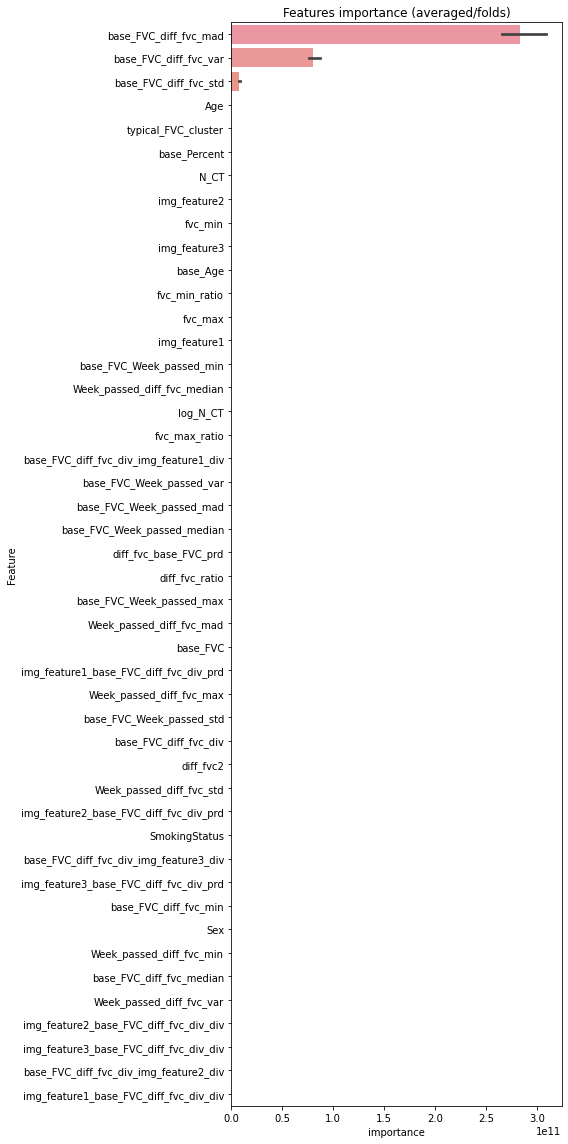

In [74]:
target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = []
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week', 'WHERE']
features = [c for c in features if c not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)
        
lgb_model_param = {
    'num_class': 2,
    # 'objective': 'regression',
    'metric': 'None',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'seed': SEED,
    "subsample_freq": 1,
    "n_jobs": -1,
    "verbose": -1,
    'num_leaves': 88,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 7,
    'min_child_weight': 200,
}
lgb_fit_param = {
    "num_boost_round": 10000,
    "verbose_eval":100,
    "early_stopping_rounds": 500,
}

feature_importance_df, predictions, oof = run_kfold_lightgbm(
    lgb_model_param, lgb_fit_param, train, test,
    folds, features, target,
    n_fold=N_FOLD, categorical=cat_features, my_loss=OSICLossForLGBM())
    
show_feature_importance(feature_importance_df, TARGET)

In [75]:
oof[:5, :]

array([[2202.99279181,    4.24077451],
       [2046.4451005 ,    4.24414629],
       [2128.67008403,    4.24283971],
       [2058.17488837,    4.24415881],
       [2083.00990584,    4.24418405]])

In [76]:
predictions[:5]

array([[2871.51961769,    4.25091227],
       [2868.38379822,    4.25089853],
       [2857.89570188,    4.25113015],
       [2868.34468444,    4.25089853],
       [2848.41601877,    4.2511334 ]])

In [77]:
train["FVC_pred"] = oof[:, 0]
train["Confidence"] = oof[:, 1]
test["FVC_pred"] = predictions[:, 0]
test["Confidence"] = predictions[:, 1]

# Submission

In [78]:
submission.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [79]:
sub = submission.drop(columns=['FVC', 'Confidence']).merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], 
                                                           on='Patient_Week')
sub.columns = submission.columns
sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2871.519618,4.250912
1,ID00421637202311550012437_-12,2824.007389,4.263786
2,ID00422637202311677017371_-12,2028.325615,4.258543
3,ID00423637202312137826377_-12,3098.076301,4.266209
4,ID00426637202313170790466_-12,2935.027360,4.252494
...,...,...,...
725,ID00419637202311204720264_133,2489.971108,4.250990
726,ID00421637202311550012437_133,2545.823265,4.262652
727,ID00422637202311677017371_133,1344.435886,4.250085
728,ID00423637202312137826377_133,2249.454110,4.267051


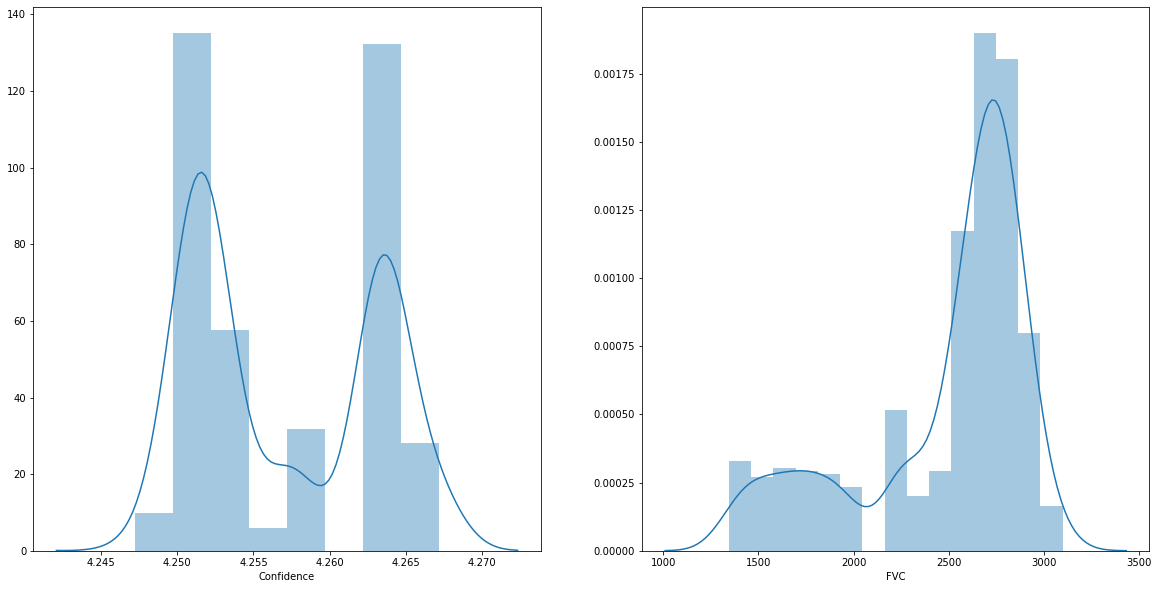

In [80]:
plt.subplot(121)
sns.distplot(sub.Confidence)
plt.subplot(122)
sns.distplot(sub.FVC);

In [81]:
model_files = []

for file in os.listdir("../input/oscitrainedmodels/"):
    if ".pth" in file:
        model_files.append(file)
model_files

['20201001_v16_train_effnet_b0_best_fold1.pth',
 '20201001_v16_train_effnet_b0_best_fold4.pth',
 '20201001_v16_train_effnet_b0_best_fold3.pth',
 '20201001_v16_train_effnet_b0_best_fold2.pth']

In [82]:
def load_models(model_files):
    models = []
    for model_f in model_files:
        model_f = os.path.join("../input/oscitrainedmodels", model_f)
        backbone = 'efficientnet-b0'
        n_features = 46
        model = enetv2(backbone, n_features)
        model.load_state_dict(torch.load(model_f, map_location=lambda storage, loc: storage), strict=True)
        model.eval()
        model.to(device)
        models.append(model)
        print(f'{model_f} loaded!')
    return models

In [83]:
models = load_models(model_files)

../input/oscitrainedmodels/20201001_v16_train_effnet_b0_best_fold1.pth loaded!
../input/oscitrainedmodels/20201001_v16_train_effnet_b0_best_fold4.pth loaded!
../input/oscitrainedmodels/20201001_v16_train_effnet_b0_best_fold3.pth loaded!
../input/oscitrainedmodels/20201001_v16_train_effnet_b0_best_fold2.pth loaded!


In [84]:
# Test data for inference
test_pt_id = test.Patient.values.tolist()
test_images_dir = [os.path.join(test_image_folder,test_pt_id[i]) for i in range(len(test_pt_id))]

test_targets = test.FVC.values

In [85]:
test.columns[5:-3]

Index(['base_FVC', 'base_Percent', 'base_Age', 'Sex', 'SmokingStatus', 'N_CT',
       'fvc_min', 'fvc_max', 'fvc_min_ratio', 'fvc_max_ratio',
       'diff_fvc_ratio', 'diff_fvc2', 'Age', 'typical_FVC_cluster',
       'base_FVC_diff_fvc_div', 'diff_fvc_base_FVC_prd', 'log_N_CT',
       'Week_passed_diff_fvc_max', 'base_FVC_Week_passed_max',
       'Week_passed_diff_fvc_min', 'base_FVC_diff_fvc_min',
       'base_FVC_Week_passed_min', 'Week_passed_diff_fvc_median',
       'base_FVC_diff_fvc_median', 'base_FVC_Week_passed_median',
       'Week_passed_diff_fvc_mad', 'base_FVC_diff_fvc_mad',
       'base_FVC_Week_passed_mad', 'Week_passed_diff_fvc_var',
       'base_FVC_diff_fvc_var', 'base_FVC_Week_passed_var',
       'Week_passed_diff_fvc_std', 'base_FVC_diff_fvc_std',
       'base_FVC_Week_passed_std', 'img_feature1', 'img_feature2',
       'img_feature3', 'base_FVC_diff_fvc_div_img_feature1_div',
       'img_feature1_base_FVC_diff_fvc_div_prd',
       'img_feature1_base_FVC_diff_fvc_div

In [86]:
#Preprocessing
meta_col = test.columns[5:-3]
scaler = StandardScaler()

test_meta = test[meta_col]
test_meta= scaler.fit_transform(test_meta)  
test_meta = np.array(test_meta, dtype=np.float32)

test_dataset = OsciDataset(
    image_paths=test_images_dir,
    data_dic=data_dic,
    targets=test_targets,
    augmentations=valid_aug,
    meta_features=test_meta
    )

test_loader = torch.utils.data.DataLoader(
      test_dataset, 
      batch_size=test_bs, 
      shuffle=False, 
      num_workers=os.cpu_count(),
      pin_memory=True
      )

In [87]:
all_prediction = np.zeros((test.shape[0], 3))

for model in models:
    predictions = []
    with torch.no_grad():
        for data in tqdm(test_loader):
          inputs = data["image"]


          inputs[0] = inputs[0].to(device, dtype=torch.float) 
          inputs[1] = inputs[1].to(device, dtype=torch.float)
          
          outputs = model(inputs)
          predictions.extend(outputs.cpu().detach().numpy())

    all_prediction += np.array(predictions)/len(models)

In [88]:
test2["Confidence"] = np.abs(all_prediction[:,2] - all_prediction[:,0])
test2["FVC"] = all_prediction[:,1]
test2["FVC"] *= 0.996
test2

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,...,img_feature1_base_FVC_diff_fvc_div_prd,img_feature1_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature2_div,img_feature2_base_FVC_diff_fvc_div_prd,img_feature2_base_FVC_diff_fvc_div_div,base_FVC_diff_fvc_div_img_feature3_div,img_feature3_base_FVC_diff_fvc_div_prd,img_feature3_base_FVC_diff_fvc_div_div,WHERE,Confidence
12144,ID00419637202311204720264,-12,3308.928051,ID00419637202311204720264_-12,6,2870.328566,66.720794,73,1,1,...,593.625275,0.0,64.27,6837.011423,0.0,112.0,3541.273225,0.0,test,341.428833
12145,ID00419637202311204720264,-11,3302.886093,ID00419637202311204720264_-11,6,2870.328566,66.622780,73,1,1,...,593.625275,0.0,64.27,6294.310916,0.0,112.0,3541.273225,0.0,test,339.737732
12146,ID00419637202311204720264,-10,3257.670404,ID00419637202311204720264_-10,6,2870.328566,66.432109,73,1,1,...,255.075130,0.0,25.00,2135.074628,0.0,40.0,1343.869733,0.0,test,323.719421
12147,ID00419637202311204720264,-9,3275.675670,ID00419637202311204720264_-9,6,2870.328566,66.553831,73,1,1,...,441.688538,0.0,43.00,3697.098923,0.0,69.0,2327.047157,0.0,test,329.764832
12148,ID00419637202311204720264,-8,3251.010323,ID00419637202311204720264_-8,6,2870.328566,66.363621,73,1,1,...,206.489391,0.0,20.00,1728.393746,0.0,32.0,1087.894546,0.0,test,321.832886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,ID00426637202313170790466,129,3141.394517,ID00426637202313170790466_129,0,2950.337935,66.605716,73,1,0,...,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test,309.475708
12870,ID00426637202313170790466,130,3139.127620,ID00426637202313170790466_130,0,2950.337935,66.550044,73,1,0,...,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test,309.151978
12871,ID00426637202313170790466,131,3142.937210,ID00426637202313170790466_131,0,2950.337935,66.644049,73,1,0,...,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test,309.687500
12872,ID00426637202313170790466,132,3136.143754,ID00426637202313170790466_132,0,2950.337935,66.477389,73,1,0,...,8.207352,0.0,1.00,127.433315,1.0,2.0,79.938715,1.0,test,308.726440


In [89]:
submission2 = submission2.drop(columns=['FVC', 'Confidence'])
sub2 = submission2.merge(test2[['Patient_Week', 'FVC', 'Confidence']], on='Patient_Week')
sub2.to_csv('submission.csv', index=False)
sub2

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3308.928051,341.428833
1,ID00421637202311550012437_-12,3222.506267,345.817505
2,ID00422637202311677017371_-12,1705.184736,200.121460
3,ID00423637202312137826377_-12,3825.999591,433.149780
4,ID00426637202313170790466_-12,3518.425502,385.637390
...,...,...,...
725,ID00419637202311204720264_133,2789.546514,268.467529
726,ID00421637202311550012437_133,2869.472717,277.086365
727,ID00422637202311677017371_133,1282.541492,213.622162
728,ID00423637202312137826377_133,2572.875176,263.511719


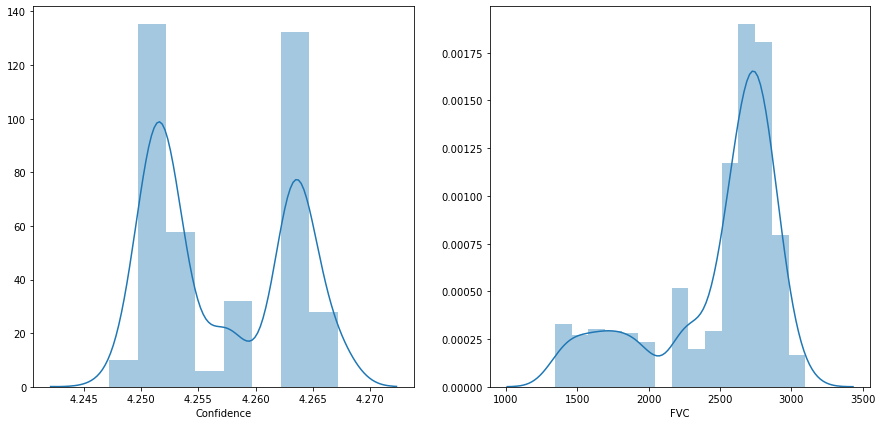

In [90]:
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.distplot(sub.Confidence)
plt.subplot(122)
sns.distplot(sub.FVC);

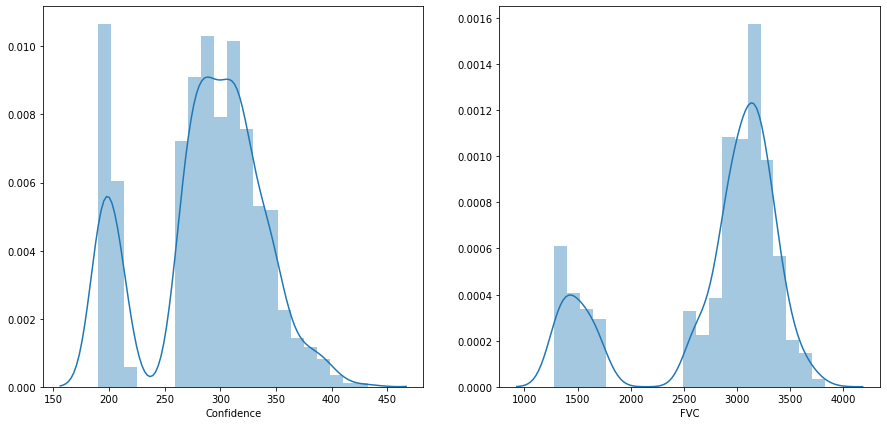

In [91]:
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.distplot(sub2.Confidence)
plt.subplot(122)
sns.distplot(sub2.FVC);

In [92]:
sub.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2481.303534,4.257063
std,444.147004,0.006044
min,1344.435886,4.247222
25%,2249.992137,4.251435
50%,2669.573149,4.253812
75%,2781.552100,4.263306
max,3098.076301,4.267171


In [93]:
sub2.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2774.179844,286.893492
std,684.617711,52.225626
min,1282.531856,189.940674
25%,2645.169447,266.348450
50%,3031.598009,293.632660
75%,3207.459472,320.085419
max,3825.999591,433.149780


In [94]:
sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2871.519618,4.250912
1,ID00421637202311550012437_-12,2824.007389,4.263786
2,ID00422637202311677017371_-12,2028.325615,4.258543
3,ID00423637202312137826377_-12,3098.076301,4.266209
4,ID00426637202313170790466_-12,2935.027360,4.252494
...,...,...,...
725,ID00419637202311204720264_133,2489.971108,4.250990
726,ID00421637202311550012437_133,2545.823265,4.262652
727,ID00422637202311677017371_133,1344.435886,4.250085
728,ID00423637202312137826377_133,2249.454110,4.267051


In [95]:
sub2

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3308.928051,341.428833
1,ID00421637202311550012437_-12,3222.506267,345.817505
2,ID00422637202311677017371_-12,1705.184736,200.121460
3,ID00423637202312137826377_-12,3825.999591,433.149780
4,ID00426637202313170790466_-12,3518.425502,385.637390
...,...,...,...
725,ID00419637202311204720264_133,2789.546514,268.467529
726,ID00421637202311550012437_133,2869.472717,277.086365
727,ID00422637202311677017371_133,1282.541492,213.622162
728,ID00423637202312137826377_133,2572.875176,263.511719


In [96]:
sub3 = sub.merge(sub2, on='Patient_Week')
sub3

,Patient_Week,FVC_x,Confidence_x,FVC_y,Confidence_y
0,ID00419637202311204720264_-12,2871.519618,4.250912,3308.928051,341.428833
1,ID00421637202311550012437_-12,2824.007389,4.263786,3222.506267,345.817505
2,ID00422637202311677017371_-12,2028.325615,4.258543,1705.184736,200.121460
3,ID00423637202312137826377_-12,3098.076301,4.266209,3825.999591,433.149780
4,ID00426637202313170790466_-12,2935.027360,4.252494,3518.425502,385.637390
...,...,...,...,...,...
725,ID00419637202311204720264_133,2489.971108,4.250990,2789.546514,268.467529
726,ID00421637202311550012437_133,2545.823265,4.262652,2869.472717,277.086365
727,ID00422637202311677017371_133,1344.435886,4.250085,1282.541492,213.622162
728,ID00423637202312137826377_133,2249.454110,4.267051,2572.875176,263.511719


In [97]:
sub3["FVC"] = 0.0
sub3["Confidence"] = 0.0

In [98]:
for i in range(len(sub3)):
    sub3["FVC"][i] = (sub3.FVC_x[i] * 0.8) + (sub3.FVC_y[i] * 0.2)
    sub3["Confidence"][i] = (sub3.Confidence_x[i] * 0.8) + (sub3.Confidence_y[i] * 0.2)
sub3

,Patient_Week,FVC_x,Confidence_x,FVC_y,Confidence_y,FVC,Confidence
0,ID00419637202311204720264_-12,2871.519618,4.250912,3308.928051,341.428833,2959.001304,71.686496
1,ID00421637202311550012437_-12,2824.007389,4.263786,3222.506267,345.817505,2903.707164,72.574530
2,ID00422637202311677017371_-12,2028.325615,4.258543,1705.184736,200.121460,1963.697439,43.431127
3,ID00423637202312137826377_-12,3098.076301,4.266209,3825.999591,433.149780,3243.660959,90.042924
4,ID00426637202313170790466_-12,2935.027360,4.252494,3518.425502,385.637390,3051.706989,80.529473
...,...,...,...,...,...,...,...
725,ID00419637202311204720264_133,2489.971108,4.250990,2789.546514,268.467529,2549.886189,57.094298
726,ID00421637202311550012437_133,2545.823265,4.262652,2869.472717,277.086365,2610.553155,58.827395
727,ID00422637202311677017371_133,1344.435886,4.250085,1282.541492,213.622162,1332.057007,46.124500
728,ID00423637202312137826377_133,2249.454110,4.267051,2572.875176,263.511719,2314.138323,56.115984


In [99]:
sub3 = sub3[['Patient_Week', 'FVC', 'Confidence']]
sub3.to_csv('submission.csv', index=False)
sub3

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2959.001304,71.686496
1,ID00421637202311550012437_-12,2903.707164,72.574530
2,ID00422637202311677017371_-12,1963.697439,43.431127
3,ID00423637202312137826377_-12,3243.660959,90.042924
4,ID00426637202313170790466_-12,3051.706989,80.529473
...,...,...,...
725,ID00419637202311204720264_133,2549.886189,57.094298
726,ID00421637202311550012437_133,2610.553155,58.827395
727,ID00422637202311677017371_133,1332.057007,46.124500
728,ID00423637202312137826377_133,2314.138323,56.115984


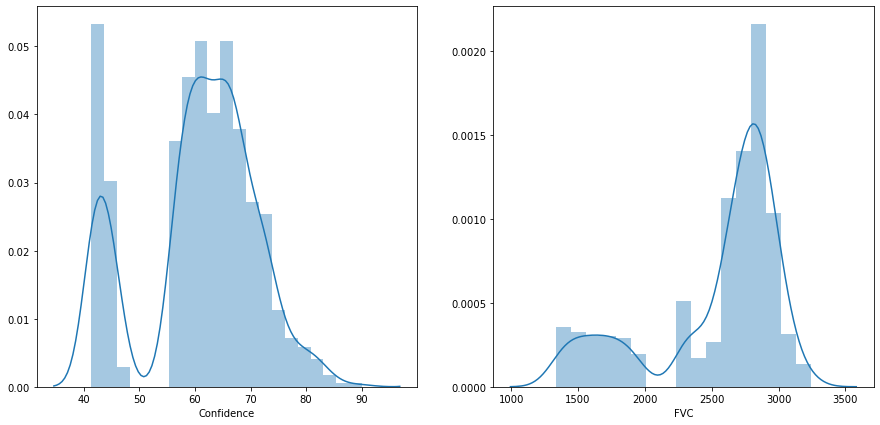

In [100]:
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.distplot(sub3.Confidence)
plt.subplot(122)
sns.distplot(sub3.FVC);

In [101]:
sub3.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2539.878796,60.784349
std,490.846515,10.445922
min,1332.055080,41.394016
25%,2329.027599,56.681498
50%,2738.410787,62.132299
75%,2864.981677,67.419190
max,3243.660959,90.042924
